# Introduction
The bike has 20 gears with a linear relationship of speed to power independently of the selected gear. So the observed speed of the app can predict the power in any gear. The advantage of this method is that gear changes does not have the need for switching to a different model.

Presumption: the trainer resistance never changes.


# Problem
Question: Find a model that predicts the Speed-by-app -> Power-by-tacx and how can we correlate each possible observing speed value with a correct power value?

# Solutione
Use two data sets of the same gear for tacx and app data and correlate an observation of the app with a observation in the tacx data set  by cadence. Cause cadence could a decimal value use a nearest neighbor regressor for each cadence/speed value in the app data.

1. Train Radius nearest neighbor regressor with distance of 0.5 so use the cadence value minus 0.5 and plus 0.5 rpm using tacx X [Cadence] -> y [power]
2. Predict power by using app's data X [cadence].
3. Create a linear model with app's data speed to predicted power values

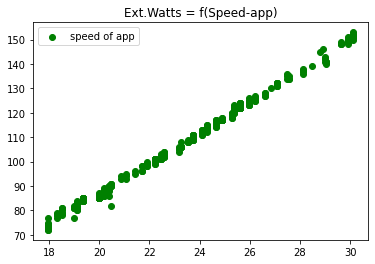

              count        mean       std    min     25%    50%     75%    max
cadence_bins                                                                  
63              2.0   72.000000  0.000000   72.0   72.00   72.0   72.00   72.0
64              2.0   73.000000  0.000000   73.0   73.00   73.0   73.00   73.0
65              2.0   74.500000  0.707107   74.0   74.25   74.5   74.75   75.0
66              1.0   77.000000       NaN   77.0   77.00   77.0   77.00   77.0
67              4.0   78.000000  0.816497   77.0   77.75   78.0   78.25   79.0
68              6.0   79.666667  1.211060   78.0   79.00   79.5   80.75   81.0
69              5.0   80.400000  1.949359   77.0   81.00   81.0   81.00   82.0
70              8.0   82.000000  1.511858   80.0   80.75   82.5   83.00   84.0
71             13.0   84.538462  0.518875   84.0   84.00   85.0   85.00   85.0
72             31.0   85.612903  0.558416   85.0   85.00   86.0   86.00   87.0
73             14.0   87.500000  0.854850   86.0   8

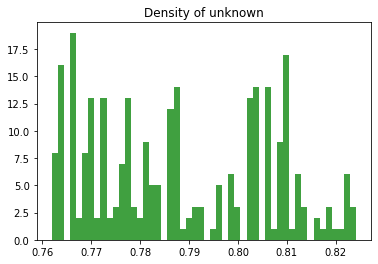

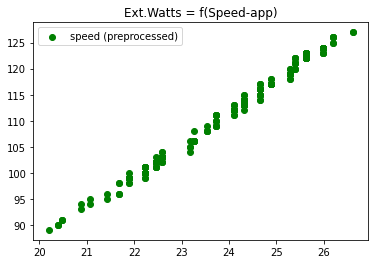

In [1]:
import numpy as np
import pandas as pd
from sklearn.base import TransformerMixin
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.neighbors import RadiusNeighborsRegressor, KNeighborsRegressor
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from src.power_by_speed.regression import create_pipeline, COLUMN_NAME_SPEED_APP, COLUMN_NAME_GEAR_RATIO
from src.power_by_speed.preprocessor import create_pipeline as create_pipeline_preprocessor
from src.validation.regression import validate_lin_reg

from src.tcx import Tcx, COLUMN_NAME_SPEED, COLUMN_NAME_WATTS, COLUMN_NAME_CADENCE, COLUMN_NAME_ACCELERATION, COLUMN_NAME_CADENCE_RATE
from src.test_data import TrainDataSet
from src.visu import plot2d, show, histogram


tcx_app_gear7: Tcx = Tcx.read_tcx(file_path='test/tcx/cadence_1612535177298-gear7.tcx')
tcx_tacx_gear7: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')
tcx_tacx_gear20: Tcx = Tcx.read_tcx(file_path='test/tcx/tacx-activity_6225123072-gear7-resistance3.tcx')

# generate test data
dts_app_gear7: TrainDataSet = TrainDataSet(tcx_app_gear7)
dts_tacx_gear7: TrainDataSet = TrainDataSet(tcx_tacx_gear7)
df_tacx_gear7 = dts_tacx_gear7.get_dataframe()
df_app_gear7 = dts_app_gear7.get_dataframe()

pipeline: Pipeline = create_pipeline(tcx_app_filename='test/tcx/cadence_1612535177298-gear7.tcx')
preprocessor: Pipeline = create_pipeline_preprocessor()

# app's speed -> power correlation (pipeline transformation)
X_train_transformed: pd.DataFrame = pipeline[0:1].fit_transform(X=df_tacx_gear7, y=df_tacx_gear7[[COLUMN_NAME_WATTS]])

def scale(X, transformer: TransformerMixin = StandardScaler()):

    columns = [COLUMN_NAME_CADENCE, COLUMN_NAME_SPEED_APP, COLUMN_NAME_WATTS]

    X_t: np.array = transformer.fit_transform(X_train_transformed[columns])

    return pd.DataFrame(data=X_t, columns=columns)

def print_stats(df: pd.DataFrame):

    print(df.assign(cadence_bins=lambda x: x[COLUMN_NAME_CADENCE].apply(lambda x : int(x)))
              .groupby(by=['cadence_bins'])[COLUMN_NAME_WATTS].describe())

# X_train_transformed = scale(X_train_transformed)

plot2d(X_train_transformed[COLUMN_NAME_SPEED_APP], X_train_transformed[COLUMN_NAME_WATTS], legend_label='speed of app', point_color='g')
show()

print_stats(df_tacx_gear7)

# find outliers

# 1. group by speed (bins) and show stats as std deviation and mean to find speeds with biggest outlierS


# 2, select & drop outliers
X_train_pp = preprocessor.fit_transform(df_tacx_gear7)

histogram(X_train_pp[COLUMN_NAME_GEAR_RATIO], bins=50)
show()

print_stats(X_train_pp)

X_train_pp = pipeline[0:1].fit_transform(X_train_pp)

plot2d(X_train_pp[COLUMN_NAME_SPEED_APP], X_train_pp[COLUMN_NAME_WATTS], legend_label='speed (preprocessed)', point_color='g')
show()



